# LLM - ROBERTA


## Libraries


In [2]:
import transformers
from transformers import AutoTokenizer, set_seed
from datasets import Dataset, DatasetDict, ClassLabel
import pandas as pd
import numpy as np
import evaluate
import torch
from transformers import pipeline
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

## Dataset

Se cargan los datasets de `training`, `validation` y `test`. Se utiliza cada uno para:

- `training` = Realizar el fine tunning del modelo.
- `validation` = validar el proceso de fine tunning.
- `test` = testear el modelo con nuevos datos.


In [3]:
df_train = pd.read_csv("../data/data_to_model/train_data.csv").rename(
    columns={"emotion": "label"}
)
df_val = pd.read_csv("../data/data_to_model/val_data.csv").rename(
    columns={"emotion": "label"}
)
df_test = pd.read_csv("../data/data_to_model/test_data.csv").rename(
    columns={"emotion": "label"}
)

### Consolidating training, validation y test:


In [4]:
# Convert the pandas DataFrame into a Dataset
df_dict_train = Dataset.from_pandas(df_train)
df_dict_train = df_dict_train.class_encode_column("label")

df_dict_val = Dataset.from_pandas(df_val)
df_dict_val = df_dict_val.class_encode_column("label")

df_dict_test = Dataset.from_pandas(df_test)
df_dict_test = df_dict_test.class_encode_column("label")


# Crear el DatasetDict con train, validation y test
emotions = DatasetDict(
    {
        "train": df_dict_train,
        "validation": df_dict_val,
        "test": df_dict_test,
    }
)


# Verificar el resultado
emotions

Casting to class labels:   0%|          | 0/6027 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/753 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/754 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 6027
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 753
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 754
    })
})

In [5]:
emotions.set_format("pandas")
df = emotions["train"][:]
df.head()

,text,label
0,when the week for exams came i got afraid as t...,2
1,i was sleeping when i heard the neighbours scr...,2
2,there was a time when my room looked terribly ...,6
3,when my friend told me that he would come and ...,4
4,"when i saw the film ""johnny got his gun"" which...",5


In [6]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)


df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,when the week for exams came i got afraid as t...,2,fear
1,i was sleeping when i heard the neighbours scr...,2,fear
2,there was a time when my room looked terribly ...,6,shame
3,when my friend told me that he would come and ...,4,joy
4,"when i saw the film ""johnny got his gun"" which...",5,sadness


In [7]:
emotions.reset_format()

## Roberta-base


## Tokenize Text


In [9]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(
    "FacebookAI/roberta-base", clean_up_tokenization_spaces=True
)

print("The vocabulary size is:", tokenizer.vocab_size)
print("Maximum context size:", tokenizer.model_max_length)
print(
    "Name of the fields, model need in the forward pass:", tokenizer.model_input_names
)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

The vocabulary size is: 50265
Maximum context size: 512
Name of the fields, model need in the forward pass: ['input_ids', 'attention_mask']


In [10]:
# Tokenize
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=False)

In [11]:
tokenize(emotions["train"][:2])

{'input_ids': [[0, 14746, 5, 186, 13, 15734, 376, 939, 300, 6023, 25, 7, 141, 939, 74, 3692, 5, 1142, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 118, 21, 8416, 77, 939, 1317, 5, 10689, 11347, 6, 939, 3723, 2462, 196, 149, 5, 2931, 8, 794, 10, 23503, 1437, 667, 7, 2914, 127, 14915, 18, 790, 2]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [12]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/6027 [00:00<?, ? examples/s]

Map:   0%|          | 0/753 [00:00<?, ? examples/s]

Map:   0%|          | 0/754 [00:00<?, ? examples/s]

In [13]:
emotions_encoded["train"].column_names

['text', 'label', 'input_ids', 'attention_mask']

## Analyzing encoded text


In [14]:
import torch
import torch.nn as nn

In [15]:
from transformers import AutoModel

model_ckpt = "FacebookAI/roberta-base"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
def extract_hidden_states(batch):
    inputs = {
        k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names
    }
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state

    return {"hidden state": last_hidden_state[:, 0].cpu().numpy()}

In [17]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
print(type(emotions_encoded["train"]["input_ids"]))

<class 'torch.Tensor'>


In [18]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/6027 [00:00<?, ? examples/s]

Map:   0%|          | 0/753 [00:00<?, ? examples/s]

Map:   0%|          | 0/754 [00:00<?, ? examples/s]

In [19]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden state']

In [20]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden state"])
X_valid = np.array(emotions_hidden["validation"]["hidden state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
print(X_train.shape, X_valid.shape)

(6027, 768) (753, 768)


### PCA


In [21]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

pca = PCA(n_components=2)

x_scaled = MinMaxScaler().fit_transform(X_train)
x_2d = pca.fit_transform(x_scaled)
x_2d.shape

(6027, 2)

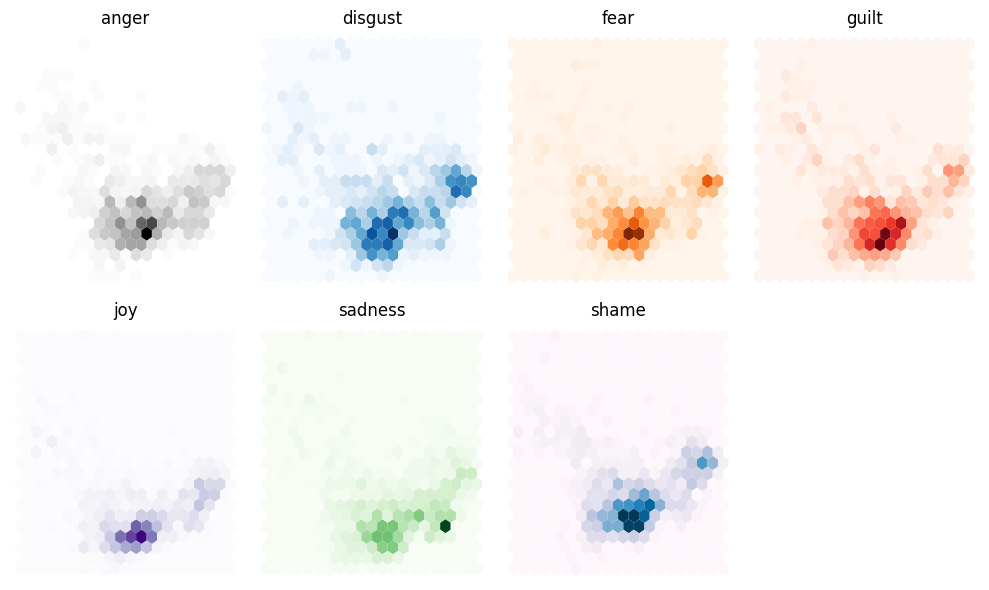

In [22]:
fig, ax = plt.subplots(2, 4, figsize=(10, 6))
ax = ax.flatten()

# Ensure we have enough colormaps for all labels
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens", "PuBu"]
labels = emotions["train"].features["label"].names

# Plot for each label
for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    x_2d_sub = x_2d[y_train == i]
    ax[i].hexbin(
        x_2d_sub[:, 0], x_2d_sub[:, 1], cmap=cmap, gridsize=20, linewidths=(0,)
    )
    ax[i].set_title(label)
    ax[i].set_axis_off()

# Hide the extra subplot (8th one) if it exists
if len(ax) > len(labels):
    ax[-1].set_visible(False)

plt.tight_layout()
plt.show()

### UMAP


In [32]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train

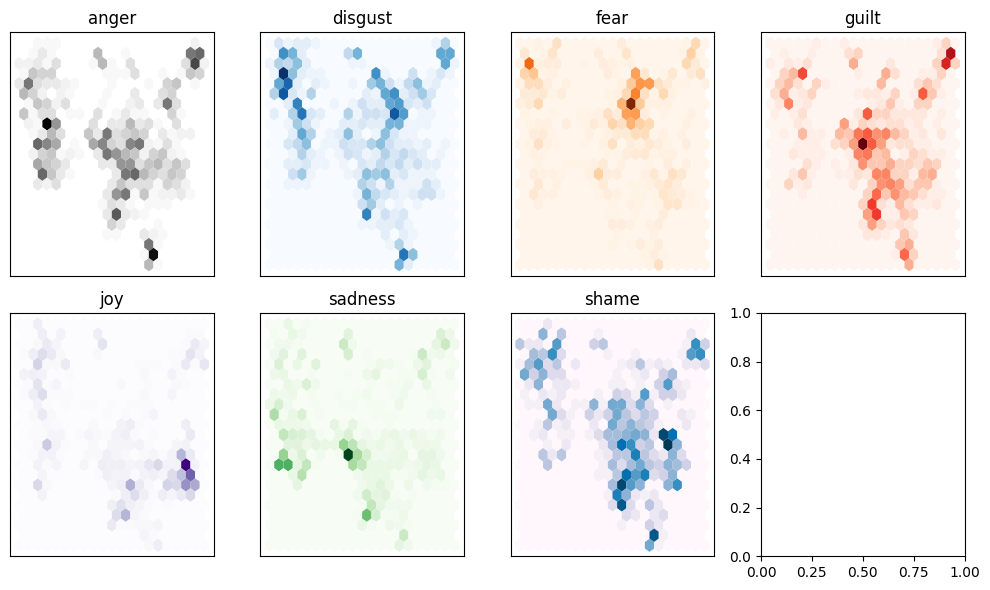

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(10, 6))

axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens", "PuBu"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(
        df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap, gridsize=20, linewidths=(0,)
    )
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

### Base Models with tokenized Data


In [28]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=5000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.5803452855245684

In [29]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")  # Predict the most frequent
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.14475431606905712

In [30]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


def plot_confusion_matrix(y_pred, y_true, labels):
    cm = confusion_matrix(y_true, y_pred, normalize="true")
    _, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

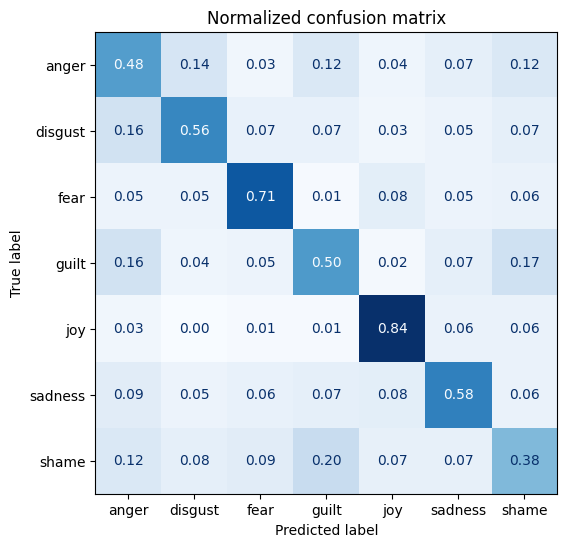

In [31]:
y_pred = lr_clf.predict(X_valid)
plot_confusion_matrix(y_pred, y_valid, labels)

## Fine-tuning


In [33]:
from transformers import AutoModelForSequenceClassification

num_labels = 7
model = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt, num_labels=num_labels
).to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
from sklearn.metrics import accuracy_score, f1_score


def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [35]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-isear"

training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=10,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    disable_tqdm=False,
    logging_steps=logging_steps,
    log_level="error",
    report_to="none",
)

In [36]:
# Make all tensors in the model contiguous before training
def make_model_contiguous(model):
    for buffer in model.buffers():
        if not buffer.is_contiguous():
            buffer.data = buffer.data.contiguous()
    for param in model.parameters():
        if not param.data.is_contiguous():
            param.data = param.data.contiguous()


make_model_contiguous(model)

In [37]:
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=emotions_encoded["train"],
    eval_dataset=emotions_encoded["validation"],
    tokenizer=tokenizer,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.443600,0.929770,0.713147,0.708345
2,0.838600,0.806440,0.730412,0.729067
3,0.658700,0.827003,0.725100,0.726566
4,0.549400,0.839583,0.727756,0.730386
5,0.437300,0.862686,0.738380,0.738488
6,0.367200,0.898041,0.733068,0.733036
7,0.298100,0.942421,0.735724,0.736115
8,0.251500,0.969282,0.723772,0.724003
9,0.213800,0.988539,0.725100,0.725318
10,0.187900,1.002733,0.734396,0.734865


TrainOutput(global_step=950, training_loss=0.5209027345556961, metrics={'train_runtime': 718.6274, 'train_samples_per_second': 83.868, 'train_steps_per_second': 1.322, 'total_flos': 2199116171164500.0, 'train_loss': 0.5209027345556961, 'epoch': 10.0})

In [38]:
preds_output = trainer.predict(emotions_encoded["validation"])

In [39]:
preds_output.metrics

{'test_loss': 0.8064402341842651,
 'test_accuracy': 0.7304116865869854,
 'test_f1': 0.7290665148059563,
 'test_runtime': 2.741,
 'test_samples_per_second': 274.721,
 'test_steps_per_second': 4.378}

In [40]:
y_preds = np.argmax(preds_output.predictions, axis=1)

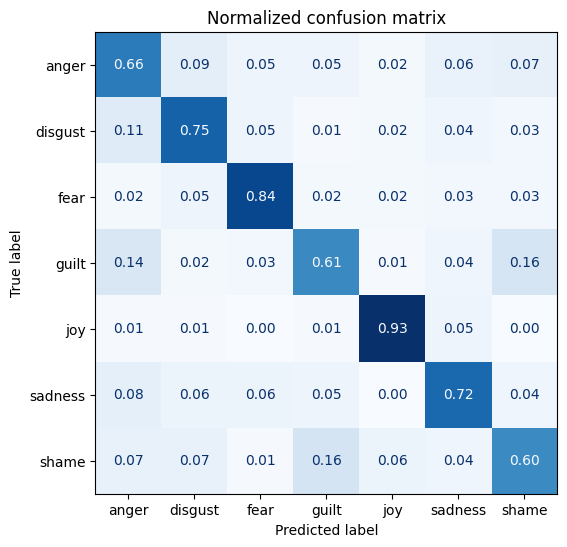

In [41]:
plot_confusion_matrix(y_preds, y_valid, labels)

In [42]:
trainer.save_model(f"models/{model_ckpt}-finetuned-isear")

## Predictions on test dataset


In [43]:
emotions_hidden["test"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden state']

In [44]:
# Evaluar el modelo en el conjunto de prueba
test_results = trainer.evaluate(eval_dataset=emotions_hidden["test"])

# Imprimir los resultados de las métricas en el conjunto de prueba
test_results

{'eval_loss': 0.7516785264015198,
 'eval_accuracy': 0.7440318302387268,
 'eval_f1': 0.7408122412540414,
 'eval_runtime': 2.5178,
 'eval_samples_per_second': 299.473,
 'eval_steps_per_second': 4.766,
 'epoch': 10.0}

In [45]:
preds_output = trainer.predict(emotions_encoded["test"])

In [46]:
y_pred_test = np.argmax(preds_output.predictions, axis=1)
len(y_pred_test)

754

In [47]:
preds_output.metrics

{'test_loss': 0.7516785264015198,
 'test_accuracy': 0.7440318302387268,
 'test_f1': 0.7408122412540414,
 'test_runtime': 2.4739,
 'test_samples_per_second': 304.778,
 'test_steps_per_second': 4.851}

In [48]:
y_test = np.array(emotions_hidden["test"]["label"])
len(y_test)

754

Classification Report:
              precision    recall  f1-score   support

       anger       0.66      0.63      0.65       109
     sadness       0.69      0.78      0.73       107
       shame       0.84      0.83      0.84       109
       guilt       0.68      0.70      0.69       106
     disgust       0.86      0.98      0.92       109
        fear       0.79      0.72      0.75       108
         joy       0.66      0.56      0.60       106

    accuracy                           0.74       754
   macro avg       0.74      0.74      0.74       754
weighted avg       0.74      0.74      0.74       754



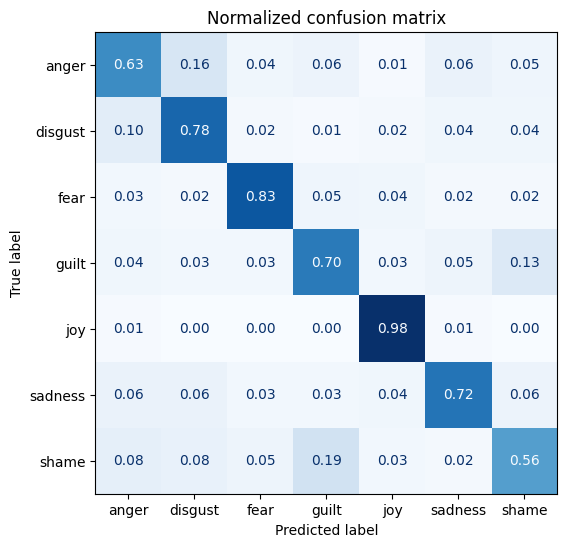

,Model,Method,Test Accuracy,Test Macro Precision,Test Macro Recall,Test Macro F1-Score
0,FacebookAI/roberta-base,Fine Tuning,0.744032,0.740422,0.743169,0.740052


In [49]:
# Initialize an empty list to store results
results = []

# Step 1: Classification metrics
print("Classification Report:")
report = classification_report(
    y_test,
    y_pred_test,
    output_dict=True,
    target_names=df_test["label"].unique(),
)
print(
    classification_report(
        y_test,
        y_pred_test,
        target_names=df_test["label"].unique(),
    )
)

# Extract important metrics from the classification report for the test set
accuracy = report["accuracy"]
macro_precision = report["macro avg"]["precision"]
macro_recall = report["macro avg"]["recall"]
macro_f1 = report["macro avg"]["f1-score"]

# Store the metrics in the results list
results.append(
    {
        "Model": model_ckpt,
        "Method": "Fine Tuning",
        "Test Accuracy": accuracy,
        "Test Macro Precision": macro_precision,
        "Test Macro Recall": macro_recall,
        "Test Macro F1-Score": macro_f1,
    }
)

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

plot_confusion_matrix(y_pred_test, y_test, labels)

results_df

## Roberta-large


In [50]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(
    "FacebookAI/roberta-large", clean_up_tokenization_spaces=True
)

print("The vocabulary size is:", tokenizer.vocab_size)
print("Maximum context size:", tokenizer.model_max_length)
print(
    "Name of the fields, model need in the forward pass:", tokenizer.model_input_names
)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

The vocabulary size is: 50265
Maximum context size: 512
Name of the fields, model need in the forward pass: ['input_ids', 'attention_mask']


In [51]:
# Tokenize
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=False)

In [52]:
tokenize(emotions["train"][:2])

{'input_ids': [[0, 14746, 5, 186, 13, 15734, 376, 939, 300, 6023, 25, 7, 141, 939, 74, 3692, 5, 1142, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 118, 21, 8416, 77, 939, 1317, 5, 10689, 11347, 6, 939, 3723, 2462, 196, 149, 5, 2931, 8, 794, 10, 23503, 1437, 667, 7, 2914, 127, 14915, 18, 790, 2]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [53]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/6027 [00:00<?, ? examples/s]

Map:   0%|          | 0/753 [00:00<?, ? examples/s]

Map:   0%|          | 0/754 [00:00<?, ? examples/s]

In [54]:
emotions_encoded["train"].column_names

['text', 'label', 'input_ids', 'attention_mask']

In [55]:
model_ckpt = "FacebookAI/roberta-large"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

In [56]:
def extract_hidden_states(batch):
    inputs = {
        k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names
    }
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state

    return {"hidden state": last_hidden_state[:, 0].cpu().numpy()}

In [57]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
print(type(emotions_encoded["train"]["input_ids"]))

<class 'torch.Tensor'>


In [58]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/6027 [00:00<?, ? examples/s]

Map:   0%|          | 0/753 [00:00<?, ? examples/s]

Map:   0%|          | 0/754 [00:00<?, ? examples/s]

In [59]:
X_train = np.array(emotions_hidden["train"]["hidden state"])
X_valid = np.array(emotions_hidden["validation"]["hidden state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
print(X_train.shape, X_valid.shape)

(6027, 1024) (753, 1024)


In [62]:
# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train

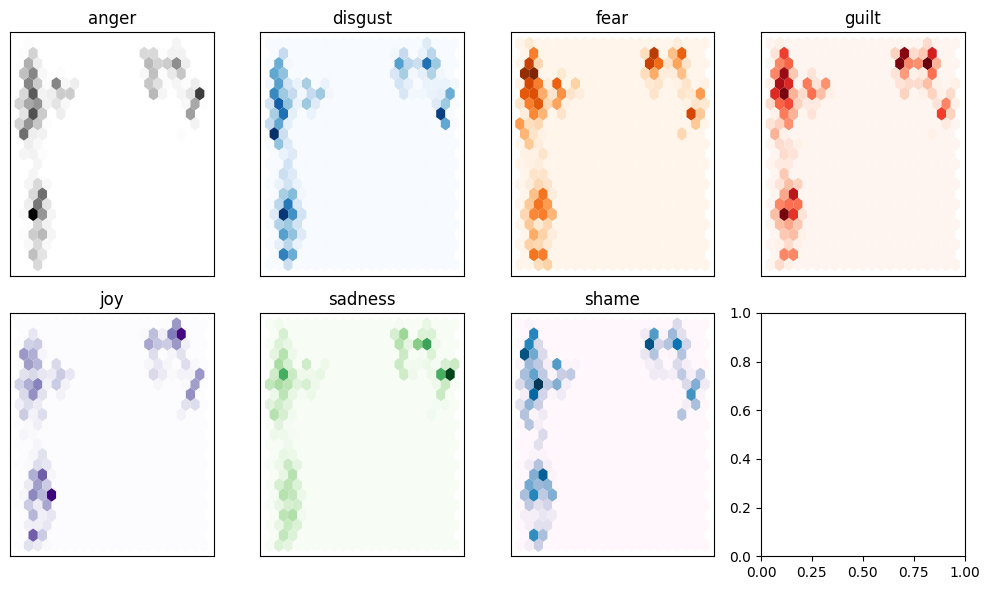

In [61]:
fig, axes = plt.subplots(2, 4, figsize=(10, 6))

axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens", "PuBu"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(
        df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap, gridsize=20, linewidths=(0,)
    )
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

### Fine-tuning


In [63]:
from transformers import AutoModelForSequenceClassification

num_labels = 7
model = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt, num_labels=num_labels
).to(device)

In [64]:
from sklearn.metrics import accuracy_score, f1_score


def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [68]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-isear"

training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=5,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    disable_tqdm=False,
    logging_steps=logging_steps,
    log_level="error",
    report_to="none",
)

In [69]:
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=emotions_encoded["train"],
    eval_dataset=emotions_encoded["validation"],
    tokenizer=tokenizer,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.458000,0.791690,0.743692,0.743992
2,0.752500,0.746202,0.755644,0.757760
3,0.582600,0.764403,0.756972,0.758512
4,0.443700,0.758958,0.771580,0.772779
5,0.353900,0.765748,0.772908,0.773391


TrainOutput(global_step=475, training_loss=0.7156490697358784, metrics={'train_runtime': 9847.4938, 'train_samples_per_second': 3.06, 'train_steps_per_second': 0.048, 'total_flos': 3894492288344490.0, 'train_loss': 0.7156490697358784, 'epoch': 5.0})

In [70]:
preds_output = trainer.predict(emotions_encoded["validation"])

In [71]:
preds_output.metrics

{'test_loss': 0.7462018728256226,
 'test_accuracy': 0.7556440903054449,
 'test_f1': 0.7577603813601439,
 'test_runtime': 47.7085,
 'test_samples_per_second': 15.783,
 'test_steps_per_second': 0.252}

In [72]:
y_preds = np.argmax(preds_output.predictions, axis=1)

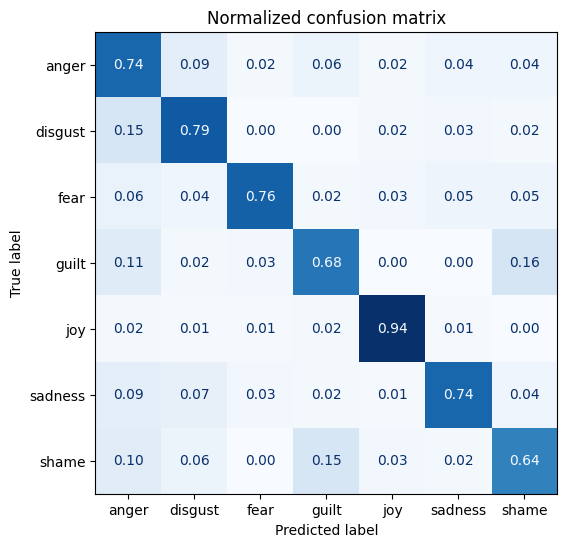

In [73]:
plot_confusion_matrix(y_preds, y_valid, labels)

## Predictions on test dataset


In [74]:
# Evaluar el modelo en el conjunto de prueba
test_results = trainer.evaluate(eval_dataset=emotions_hidden["test"])

# Imprimir los resultados de las métricas en el conjunto de prueba
test_results

{'eval_loss': 0.6661131381988525,
 'eval_accuracy': 0.773209549071618,
 'eval_f1': 0.774325490847974,
 'eval_runtime': 68.78,
 'eval_samples_per_second': 10.962,
 'eval_steps_per_second': 0.174,
 'epoch': 5.0}

In [75]:
preds_output = trainer.predict(emotions_encoded["test"])

In [76]:
y_pred_test = np.argmax(preds_output.predictions, axis=1)
len(y_pred_test)

754

In [77]:
preds_output.metrics

{'test_loss': 0.6661131381988525,
 'test_accuracy': 0.773209549071618,
 'test_f1': 0.774325490847974,
 'test_runtime': 69.3832,
 'test_samples_per_second': 10.867,
 'test_steps_per_second': 0.173}

In [78]:
y_test = np.array(emotions_hidden["test"]["label"])
len(y_test)

754

Classification Report:
              precision    recall  f1-score   support

       anger       0.68      0.75      0.72       109
     sadness       0.69      0.81      0.74       107
       shame       0.91      0.79      0.85       109
       guilt       0.74      0.71      0.72       106
     disgust       0.94      0.96      0.95       109
        fear       0.84      0.73      0.78       108
         joy       0.65      0.65      0.65       106

    accuracy                           0.77       754
   macro avg       0.78      0.77      0.77       754
weighted avg       0.78      0.77      0.77       754



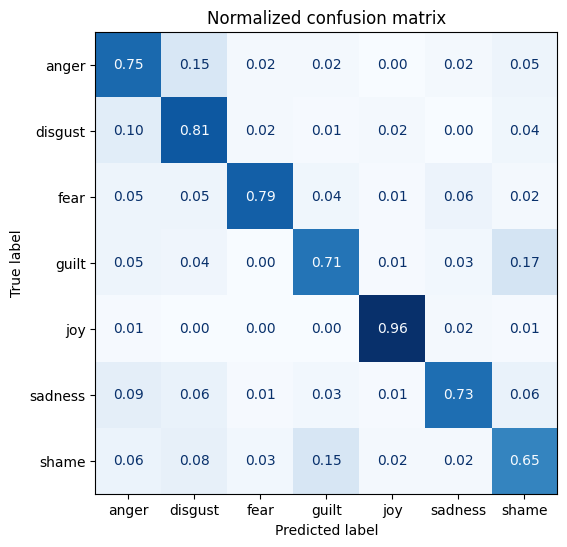

,Model,Method,Test Accuracy,Test Macro Precision,Test Macro Recall,Test Macro F1-Score
0,FacebookAI/roberta-base,Fine Tuning,0.744032,0.740422,0.743169,0.740052
0,FacebookAI/roberta-large,Fine Tuning,0.773210,0.779244,0.772520,0.773575


In [ ]:
# Initialize an empty list to store results
results = []

# Step 1: Classification metrics
print("Classification Report:")
report = classification_report(
    y_test,
    y_pred_test,
    output_dict=True,
    target_names=df_test["label"].unique(),
)
print(
    classification_report(
        y_test,
        y_pred_test,
        target_names=df_test["label"].unique(),
    )
)

# Extract important metrics from the classification report for the test set
accuracy = report["accuracy"]
macro_precision = report["macro avg"]["precision"]
macro_recall = report["macro avg"]["recall"]
macro_f1 = report["macro avg"]["f1-score"]

# Store the metrics in the results list
results.append(
    {
        "Model": model_ckpt,
        "Method": "Fine Tuning",
        "Test Accuracy": accuracy,
        "Test Macro Precision": macro_precision,
        "Test Macro Recall": macro_recall,
        "Test Macro F1-Score": macro_f1,
    }
)

# Convert results to a DataFrame
results_df = pd.concat([results_df, pd.DataFrame(results)])

plot_confusion_matrix(y_pred_test, y_test, labels)

results_df

In [80]:
results_df.to_excel("../data/model_results/roberta.xlsx", index=False)